# Earthquakes and Self-Organized Criticality

## Introduction

Due to the catastrophic nature of large earthquakes scientists are searching for ways to predict when they might occur. One subject that is not yet completely understood is self-organized criticality (SOC) in the earth's crust. This is the tendency for the earth to be shifted towards a critical point in which large earthquakes can happen. If the earth were in a constant state of SOC, then an earthquake could happen at any time, and each earthquake has an equally likely chance of being catastrophic. However, there is evidence to suggest that this is not the case. For example, the majority of large earthquakes tend to be preceded by a buildup of smaller events $^{[2]}$. This has lead scientists to believe that there are windows in which the earth's crust is in a critical period for large earthquakes. If this is the case, and we are able to determine when these critical periods are, we may be able to predict when large earthquakes are going to occur, and this could save countless lives. 

One commonly used model for earthquakes was proposed by Burridge and Knopoff in 1967. It contains a series of blocks and springs in between two plates on the top and bottom, shown in the figure below. This represents a fault line in the earth's crust. The top and bottom plates represent two of the earth's adjacent plates that slide past each other at a constant rate over time. The top plate moves at a steady and slow velocity, and it is connected to each block by a leaf spring. As a result, the leaf springs will slowly build up tension until a block moves. This may cause other blocks to move due to the force from the block springs. Any sudden motion in a block or a group of blocks represents an earthquake. In my version this model, the friction force between the bottom plate and the blocks decreases as the velocity of the block increases. This is a one-dimensional block-spring model, and it can be expanded to two dimensions for a more accurate depiction $^{[1]}$.

![image.png](Spring Force Diagram.png)

The size of an earthquake is measured using the Richter scale. It is a logarithmic scale that is proportional to the amount one plate shifts relative to another. It is logarithmic, because it there are a wide range of possible magnitudes, and small earthquakes are by far more common than large ones. The Gutenberg-Richter law states the probability of an earthquake with a specific magnitude occurring:

\begin{equation*}    
P (M) = Ae^{-bM}
\end{equation*}

Where M is the magnitude, which is represented in Burridge and Knopoff's model by the logarithm of the total distance the blocks have shifted. In nature we tend to see b values that range from 0.8 to 1.5$^{[1]}$. If a model can produce data with a similar b value, it is likely to be relatively accurate, and it can be used to predict the nature of real earthquakes.

## Model

The equations that model the spring force on the blocks $^{[1]}$:  
* Spring force on block from neighboring blocks:
    
\begin{equation*}    
F_b = -k_c(x_i - x_{i+1}) - k_c(x_i - x_{i-1}) 
\end{equation*}

* Leaf Spring Force from the top plate on block: 

\begin{equation*}    
F_l = -k_p(x_i - v_0 t)
\end{equation*} 
    
* Friction force due to bottom plate: 

\begin{equation*}
F_f = -\frac{F_0 sin(v_i)}{1 + |v_i / v_f|}
\end{equation*}

Overall differential equation of motion:  
* This equation combines the above equations into one differential equation that relates the position of block i and its neighboring blocks to the total force acting on block i.

\begin{equation*}
m_i \frac{d^2 x_i}{dt^2} = k_c(x_{i+1} + x_{i-1} - 2x_i) + k_p(v_0 t - x_i) + F_f
\end{equation*}

Where for each block:  
$F_b$ is force from neighboring block  
$F_l$ is the force from the leaf spring  
$F_f$ is the friction force from the bottom plate  
$k_c$ is the spring constant of springs between blocks  
$k_l$ is the spring constant of the leaf springs  
$x_i$ is the position of block i with respect to equilibrium position  
$v_i$ is the velocity of block i  
$m_i$ is the mass of block i  
$V_0$ is the static friction force  
$V_f$ is the friction coefficient that determines how friction relates to velocity

This simulation uses models with 25 blocks and 100 blocks. The two blocks at the ends are free, so they only experience spring force from one other block and the leaf spring. The overall force equation is applied to each block at a specific time, given the positions of all the blocks at that time.

**Boundary Conditions: **
At t = 0, the blocks are set an average of one distance unit apart with a random variation of 0.001 distance units. There is no limit to how far the blocks can travel as a whole, but a single block is not able to move past the position of a neighboring block.

## Numerical Methods

This model follows the one dimensional block and spring model proposed by Burridge and Knopoff. The friction force between the blocks and the bottom plate is a function of the velocity of the block. It decreases as the velocity increases. To calculate the position and velocity of the blocks over time, I used the Euler method. I adapted this method to process an array of block positions and velocities at each step. I also incorporated an adaptive step size in order to decrease the time it takes to process a large amount of data. When none of the blocks are moving, the step size is large (1 time unit), and when any of the blocks are moving, the step size is much small (0.005 time units). At time t = 0, the blocks are within 0.001 distance units of their equilibrium positions, and the variation in their positions is random.  

To count the earthquakes that occurred over the specified timeframe, I used the following equation: 

\begin{equation*}    
M = \sum_{n=time}\big(\sum_{i=blocks} v_i \Delta t \big)
\end{equation*}

Where M is the total moment of the earthquake$^{[1]}$. I implemented this in my code so that it uses the velocity over time data. I marked the start of each earthquake by an increase in velocity, and I set the maximum length of an earthquake to 1 second, to prevent two earthquakes from becoming combined into one.

After following the model proposed in Gionardo's book, and calculating a constant for the Gutenberg-Richter law, I decided to test how varying the masses of the blocks would affect the outcome of this calculation. To do this, I defined a new motion function that takes an array of masses instead of a single value. Most of the large data collection was conducted in the file Big Data Collection, and then the results were copied to this file.

In [1]:
import pylab as plt
import numpy as np
import random
%matplotlib inline

In [2]:
def friction (vi, vf, F0):
    """
    Returns the friction of the bottom plate against blocks moving at a specific velocity
    
    Arguments:  vi - initial velocity of the block
                vf - final velocity of the block
                F0 - the static friction force
    
    Returned: The force due to friction
    
    Examples:
    
    >>> friction (0, 1, 20)
    -20.0
    
    >>> friction (1, 1, 20)
    -10.0
    """
    # Calculates sign of vi
    if vi == 0:
        sign = 1
        
    else:
        sign = vi / abs(vi)
        
    force = -((F0) * sign / (1 + abs(vi/vf)))
    return force

In [3]:
def blockMotion (t, blockPositions, vBlock, i, blockNum, kp, kc, mass, F0, v0, vf):
    """
    Returns the differential equation that models the motion of the blocks
    
    Arguments:  t - time
                blockPositions - the positions of the blocks
                vBlock - the velocity of the block
                i - the index of the current block
                blockNum - the number of blocks
                kp - spring constant of leaf springs
                kc - spring constant of springs between blocks
                mass - mass of individual block
                F0 - the static friction force
                v0 - initial velocity of top plate
                vf - the friction coefficient
                
    Returned: The differential equation modeling the motion of the individual blocks
    
    Examples:
    
    >>> blockMotion (0, (0, 1, 2, 3, 4), 0, 2, 5, 0, 0, 1, 0, 1, 20)
    array([ 0.,  0.])
    
    """
    # Sets position and velocity of the block
    xi = blockPositions[i] - i
    vi = vBlock
    
    # Block motion for the first block, connected to a block one distance unit away
    if i == 0:
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP - xi) + kp * (v0 * t - xi)
    
    # Block motion for the last block, connected to a block one distance unit away
    elif i == blockNum - 1:
        xiM = blockPositions[i - 1] - (i - 1)
        springForce = kc*(xiM - xi) + kp * (v0 * t - xi)
   
    # Block motion for all the middle blocks, connected to their neighbors
    else:
        xiM = blockPositions[i - 1] - (i - 1)
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi)
    
    frictionForce = friction (vi, vf, F0)
    
    # If spring force is large enough to overpower friction, change velocity
    if abs(springForce) <= abs(frictionForce):
        dv = -vi
        vi = 0
        dx = vi
    
    else: 
        totalForce = (springForce + frictionForce) / mass
        dx = vi
        dv = totalForce
        
    return np.array([dx, dv], float)

In [4]:
def blockMotionVaryingMasses (t, blockPositions, vBlock, i, blockNum, kp, kc, mass, F0, v0, vf):
    """
    Returns the differential equation that models the motion of the blocks
    
    Arguments:  t - time
                blockPositions - the positions of the blocks
                vBlock - the velocity of the block
                i - the index of the current block
                blockNum - the number of blocks
                kp - spring constant of leaf springs
                kc - spring constant of springs between blocks
                mass - masses of individual blocks
                F0 - the static friction force
                v0 - initial velocity of top plate
                vf - the friction coefficient
                
    Returned: The differential equation modeling the motion of the individual blocks
    
    Examples:
    
    >>> blockMotion (0, (0, 1, 2, 3, 4), 0, 2, 5, 0, 0, 1, 0, 1, 20)
    array([ 0.,  0.])
    
    """
    # Sets position and velocity of the block
    xi = blockPositions[i] - i
    vi = vBlock
    mi = mass[i]
    
    # Block motion for the first block, connected to a block one distance unit away
    if i == 0:
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP - xi) + kp * (v0 * t - xi)
    
    # Block motion for the last block, connected to a block one distance unit away
    elif i == blockNum - 1:
        xiM = blockPositions[i - 1] - (i - 1)
        springForce = kc*(xiM - xi) + kp * (v0 * t - xi)
   
    # Block motion for all the middle blocks, connected to their neighbors
    else:
        xiM = blockPositions[i - 1] - (i - 1)
        xiP = blockPositions[i + 1] - (i + 1)
        springForce = kc*(xiP + xiM - 2 * xi) + kp * (v0 * t - xi)
    
    frictionForce = friction (vi, vf, F0)
    
    # If spring force is large enough to overpower friction, change velocity
    if abs(springForce) <= abs(frictionForce):
        dv = -vi
        vi = 0
        dx = vi
    
    else: 
        totalForce = (springForce + frictionForce) / mi
        dx = vi
        dv = totalForce
        
    return np.array([dx, dv], float)

In [5]:
def eulerCoupledAdaptive (f, n, blockPositions, vBlock, blockNum, h1, h2, maxPoints, minBlockV, *args, verbose = False):
    """ 
    Solve a coupled system of ODEs by Euler method with fixed number of steps.

    Arguements: f - function giving ODE as y'=f(x,y)
                n - the number of ODEs
                blockPositions - the array containging the initial block positions
                vBlock - initial block velocity
                blockNum - the number of blocks
                interval - tuple region (a,b) on which to solve ODE
                steps - number of steps
    
    Returned: An array containing the positions and velocies of the blocks over time
    """
    
    points = np.zeros((maxPoints, blockNum*2 + 1)) # array to contain all the block positions and velocities over time

    # set up initial point
    t = 0
    points[0,0] = t
    count = 0
    
    # Sets up first row of poitns
    for l in range(1, blockNum + 1):
        points[0,l] = blockPositions[count]   
        count += 1
    for m in range(blockNum + 1, blockNum * 2 + 1):
        points[0,m] = vBlock
    
    # initializes count, dv and r
    count = 1
    dv = 0
    r = (0,0)
    
    while points[maxPoints - 1, 0] == 0: # Repeats until points array is filled up                   
        
        # Proceeds if none of the blocks are moving
        if dv < minBlockV:
            h = h1 # Long timestep
            
            # Repeats Euler calculation until one of the blocks moves or points is full
            while dv < minBlockV and points[maxPoints - 1, 0] == 0:
                
                if verbose == True:
                    print("h1:", t)
                
                # Saves block positions and updates timestep
                oldBlockPositions = blockPositions
                t = t + h
                points[count,0] = t
                dv = 0
                
                # Repeats Euler calculation for each block
                for i in range(0, blockNum): 

                    r = np.array([points[count-1, i + 1], points[count-1, i + 1 + blockNum]]) # Updates r from previous timestep

                    r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args) # Calculates new r

                    r = r_new 
                    blockPositions[i] = r[0]
                    
                    # Updates dv
                    if r[1] > dv:
                        dv = r[1]
                        
                    if verbose == True:
                        print(i, blockPositions[i], r[1], dv)
                        
                    # Saves values to points
                    points[count,i + 1] = r[0]
                    points[count,i + 1 + blockNum] = r[1]

                count += 1
                
        # Proceeds if any of the blocks are moving        
        elif points[maxPoints - 1, 0] == 0:
            # Resets to previous timestep
            h = h2 # Short timestep
            t -= h1
            count -= 1
            blockPositions = oldBlockPositions
            dv = 0

            # Repeats Euler calculation until one of the blocks moves or points is full
            # This is necessary, because the timestep was reset, so dv will still be zero
            while dv < minBlockV and points[maxPoints - 1, 0] == 0: 
                
                if verbose == True:
                    print("h2:", t)
                
                # Saves block positions and updates timestep                
                oldBlockPositions = blockPositions
                t = t + h
                points[count,0] = t
                dv = 0

                # Repeats Euler calculation for each block                
                for i in range(0, blockNum):

                    r = np.array([points[count-1, i + 1], points[count-1, i + 1 + blockNum]]) # Updates r from previous timestep

                    r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args) # Calculates new r

                    r = r_new            
                    blockPositions[i] = r[0]
                    
                    # Updates dv
                    if r[1] > dv:
                        dv = r[1]

                    if verbose == True:
                        print(i, blockPositions[i], r[1], dv)
                        
                    # Saves values to points
                    points[count,i + 1] = r[0]
                    points[count,i + 1 + blockNum] = r[1]

                count += 1
                
            # Repeats Euler calculation until all of the blocks are still or points is full                
            while dv >= minBlockV and points[maxPoints - 1, 0] == 0: 
                
                if verbose == True:
                    print("h2:", t)
                
                # Saves block positions and updates timestep
                oldBlockPositions = blockPositions
                t = t + h
                points[count,0] = t
                dv = 0

                # Repeats Euler calculation for each block  
                for i in range(0, blockNum):

                    r = np.array([points[count-1, i + 1], points[count-1, i + 1 + blockNum]]) # Updates r from previous timestep

                    r_new = r + h * f(t, blockPositions, r[1], i, blockNum, *args) # Calculates new r

                    r = r_new            
                    blockPositions[i] = r[0]
                    
                    # Updates dv
                    if r[1] > dv:
                        dv = r[1]

                    if verbose == True:
                        print(i, blockPositions[i], r[1], dv)
                        
                    # Saves values to points
                    points[count,i + 1] = r[0]
                    points[count,i + 1 + blockNum] = r[1]

                count += 1

    return points

In [39]:
def countQuakes (earthquakes, blockNum, timeStep):
    """
    Produces a list of each earthquake and its magnitude
    
    Arguments:  earthquakes - the array containing all earthquake data
                blockNum - the number of blocks
                i - the block index to be examined
                
    Returned: a list containing the magnitude of each earthquake
    """    
    quakes = []
    time = []
    count = 0
    quakeNum = -1
    dvOld = 0
    
    # Repeats for each row of earthquakes
    while count < len(earthquakes):
        
        # Determines if any of the blocks are moving
        dv = 0
        for i in range (0, blockNum):
            if dv < earthquakes[count, blockNum + i + 1]:
                dv = earthquakes[count, blockNum + i + 1]
        
        # If any of the blocks are accelerating add an earthquake
        if dv > dvOld:
            quakeNum += 1
            quakes.append(0)
            time.append(earthquakes[count, 0])
            
            # Add the motion from all the blocks until the earthquake stops
            earthquakeLength = 0
            while dv > 0.0001 and count < len(earthquakes) - 1 and earthquakeLength < 200:

                for i in range (0, blockNum):
                    quakes[quakeNum] += earthquakes[count, blockNum + i + 1] * timeStep

                # Incriments count and recalculates dv
                count += 1            
                dv = 0
                for i in range (0, blockNum):
                    if dv < earthquakes[count, blockNum + i + 1]:
                        dv = earthquakes[count, blockNum + i + 1]
                earthquakeLength += 1
    
        else:
            count += 1
        dvOld = dv
        
    return time, quakes

In [7]:
def countMagnitudes (magnitudes):
    """
    Produces a list of the number of earthquakes that fall within a certain range of magnitudes
    
    Arguments: magnitudes - a list of magnitudes
                
    Returned: a list containing the number of occurrences of each magnitude
    """
    magValues = np.linspace(-7, 7, 29)
    occurences = np.zeros(29, int)
    
    for i in range(0, len(magnitudes)):
        count = 0
        for n in magValues:
            if magnitudes[i] >= n and magnitudes[i] < n + 0.25:
                occurences[count] += 1
            count += 1
                
    return magValues, occurences

## Results

### Example of Earthquake Model Over a Short Period of Time

In [76]:
blockPositions = [] # Array to contain random block positions
testBlockPositions = [] #Test array with set block positions
averageSpacing = 1 # Average spacing between blocks
kp = 40 # Leaf spring constant
kc = 250 # Spring constant between blocks
mass = 1 # Mass of blocks
F0 = 50 # Static friction force
v0 = 0.01 # Velocity of the top plate
vBlock = 0 # Initial velocity of blocks
vf = 3.0 # Friction coefficient
blockNum = 25 # Number of blocks
maxTimeSteps = 50000 # Total number of timesteps to be calculated
minBLockV = 1e-8 # Velocity at which small timestep will kick in
timeStepShort = 0.005 # More presice timestep
timeStepLong = 1 # Less precice timestep
variation = 0.001 # Variation in distance between blocks

# Calculates inital block positions
for n in range(0, blockNum + 1):
    blockPositions.append(n * averageSpacing + (random.random() - 0.5) * 2 * variation)
    testBlockPositions.append(n)

In [77]:
# Calculates earthquake postition and velocity over the given time range
earthquake = eulerCoupledAdaptive (blockMotion, 2, blockPositions, vBlock, blockNum, timeStepLong,\
                           timeStepShort, maxTimeSteps, minBLockV, kp, kc, mass, F0, v0, vf) 

In [78]:
# Sets up new array for plotting
earthquakePlot = np.copy(earthquake)

# Normalizes block positions relative to their equilibrium positions
for n in range(1, blockNum + 1):
    for m in range(0, maxTimeSteps):
        earthquakePlot[m,n] += -n + 1

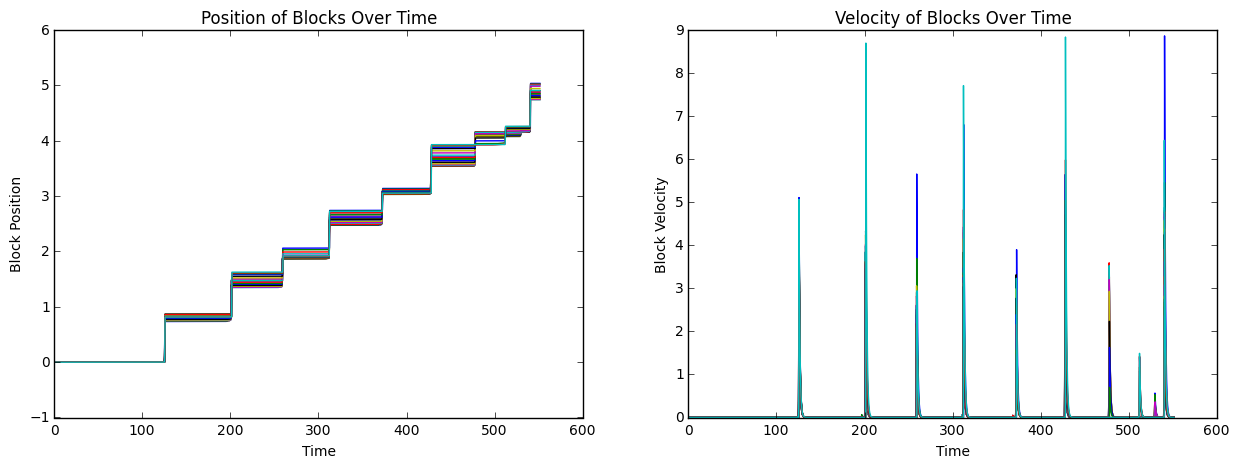

In [79]:
plt.figure(figsize = (15,5))

# Plots all of the block positions on the same plot
plt.subplot(121)
for i in range (1, blockNum + 1):
    plt.plot(earthquakePlot[:, 0], earthquakePlot[:, i])
plt.xlabel("Time")
plt.ylabel("Block Position")
plt.title("Position of Blocks Over Time")

# Plots all of the block velocities on the same plot
plt.subplot(122)
for i in range (0, blockNum):
    plt.plot(earthquakePlot[:,0], earthquakePlot[:, blockNum + i + 1])
plt.xlabel("Time")
plt.ylabel("Block Velocity")
plt.title("Velocity of Blocks Over Time")

These plots depict the change in position and velocity over a time span of about 600 time units of the series of blocks described above. In this example, there are 25 blocks with random spacing within a variation of 0.001 distance units from their equilibrium positions. They are connected by springs with a uniform kc value of 250. Each block's motion is plotted individually with its own color, and its position shown is relative to its equilibrium position.  

The left plot depicts the position of the blocks over time. The y axis represents the position of the blocks relative to their individual equilibrium position. This shows that sometimes, the blocks will move in sync with each other, and other times, only a small portion of the blocks moves at once. Each time the position of a block or group of blocks changes, an earthquake has happened, and the distance the blocks move is correlated to the magnitude of the event. Because the starting positions of the blocks was varied slightly, the time at which each event happens, and its magnitude also varies.  

The right plot depicts the velocity of the blocks over time. This matches the derivative of the position plot, and shows that the size of the earthquakes varies to a large degree.

(0.0001, 10)

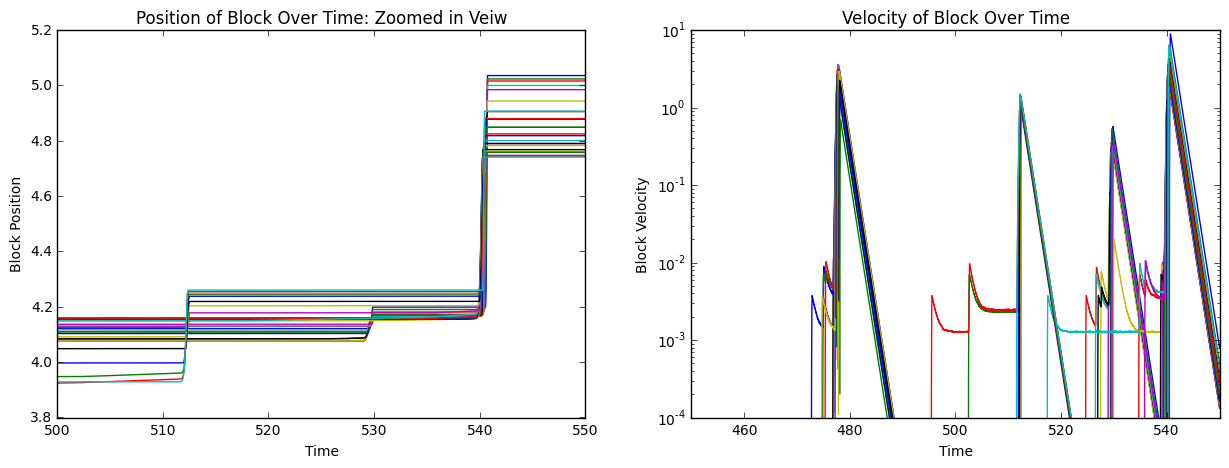

In [92]:
plt.figure(figsize = (15,5))

# Plots all of the block positions on the same plot
plt.subplot(121)
for i in range (1, blockNum + 1):
    plt.plot(earthquakePlot[:, 0], earthquakePlot[:, i])
plt.xlabel("Time")
plt.ylabel("Block Position")
plt.title("Position of Block Over Time: Zoomed in Veiw")
plt.xlim(500,550)
plt.ylim(3.8,5.2)

# Plots all of the block velocities on the same plot
plt.subplot(122)
for i in range (0, blockNum):
    plt.semilogy(earthquakePlot[:,0], earthquakePlot[:, blockNum + i + 1])
plt.xlabel("Time")
plt.ylabel("Block Velocity")
plt.title("Velocity of Block Over Time")
plt.xlim(450,550)
plt.ylim(0.0001,10)

These plots are the same as the ones above, but scaled to depict the motion of the blocks in more detail. The left plot is a zoomed in view of the positions of the blocks over a small timescale. It shows that sometimes all of the blocks move roughly in sync with each other, and sometimes, only small groups of blocks, or individual blocks move. The right plot shows the velocities of the blocks over a logarithmic scale, and a smaller timeframe. This shows that there are many small earthquakes along with the larger ones.

In [40]:
earthquakeTimes, earthquakeMoments = countQuakes(earthquakePlot, blockNum, timeStepShort)
earthquakeMagnitudes = list(map(np.log,earthquakeMoments))

C:\Users\workshop\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


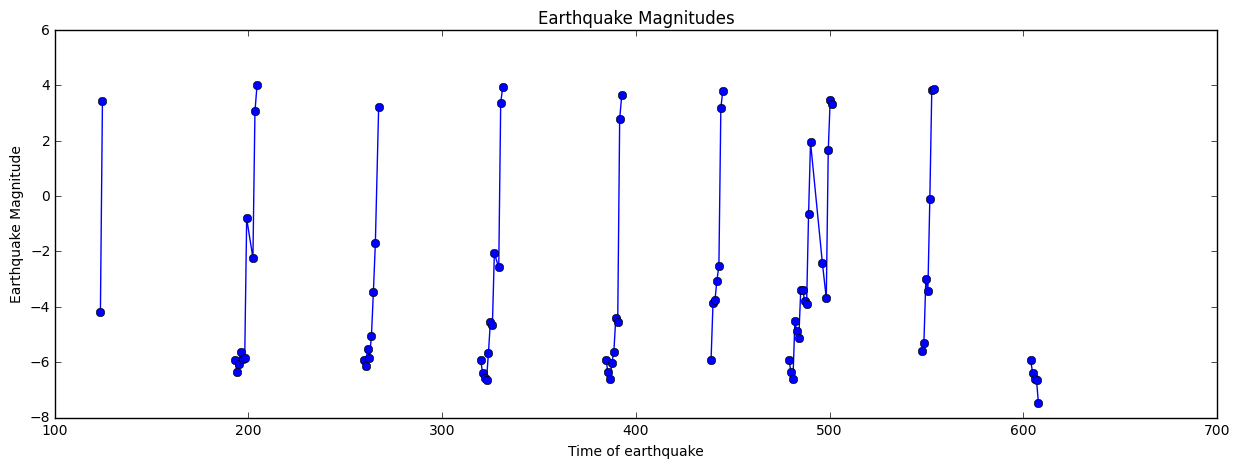

In [61]:
plt.figure(figsize = (15,5))
plt.plot(earthquakeTimes, earthquakeMagnitudes, "b-o")
plt.title("Earthquake Magnitudes")
plt.xlabel("Time of earthquake")
plt.ylabel("Earthquake Magnitude")
plt.show()

This is an example of a scatter plot that represents the magnitude of each earthquake that occurred during the above timeframe, at the time they occurred. Each blue dot represents one earthquake. The magnitude of each earthquake was measured by taking the sum of the velocity over time for each block, and then adding this value for all of the blocks together. This gave me the total moment of each earthquake. The magnitudes were then calculated by taking the logarithm of the moment. From this plot we can see a pattern forming. Generally there is a cluster of small earthquakes that lead up to a large one, and then there are no earthquakes for a long period of time.

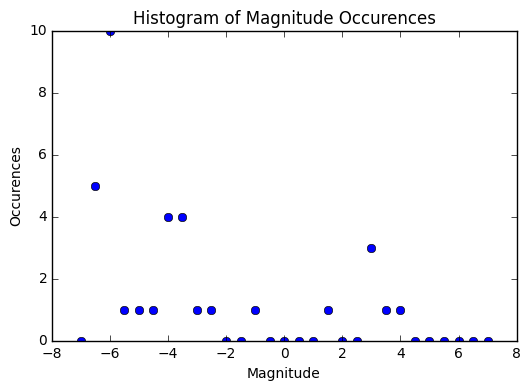

In [63]:
Magnitudes, Occurences = countMagnitudes (earthquakeMagnitudes)
plt.plot(Magnitudes, Occurences, "b o")
plt.title("Histogram of Magnitude Occurences")
plt.xlabel("Magnitude")
plt.ylabel("Occurences")

This plot is an example of a histogram of magnitude occurrences. Each blue dot represents the earthquakes within a range of 0.25 magnitude units. The y position of each dot represents the amount of earthquakes within the range that occurred in the timeframe.

### Results From Large Earthquake Model

The following data was calculated in the file Big Data Collection. It uses the same methods described above, but over 5000000 time steps instead of 50000.

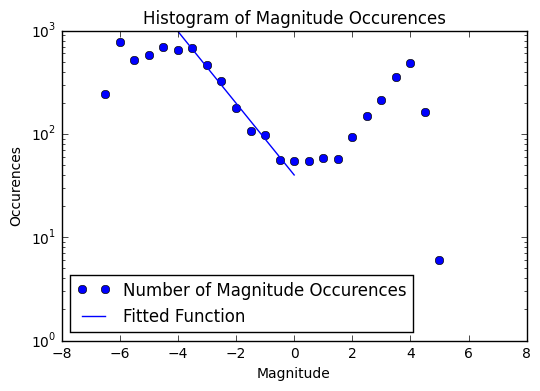

Total Number of Earthquakes:  7048


In [30]:
bigOccurences = [  0, 244, 777, 523, 576, 693, 643, 674, 463, 326, 178, 107,  97,  56,  54,  55,  58,  57,
  94, 149, 214, 352, 488, 164,   6,   0,   0,   0,   0]
bigMagnitudes = np.linspace(-7, 7, 29)

A = 40
b = 0.8
fitX = np.linspace(-4, 0)
fitY = []
for i in fitX:
    fitY.append(A * np.exp(-b * i))

plt.semilogy(bigMagnitudes, bigOccurences, "b o", label = "Number of Magnitude Occurences")
plt.semilogy(fitX, fitY, label = "Fitted Function")
plt.title("Histogram of Magnitude Occurences")
plt.xlabel("Magnitude")
plt.ylabel("Occurences")
plt.legend(loc = "best")
plt.show()
print("Total Number of Earthquakes: ", sum(bigOccurences))

The above plot is a histogram representing the number of earthquakes that occur within certain magnitude ranges in a large timeframe. This data was collected over 5000000 time steps and there were 100 blocks with uniform mass (1 mass unit). The results show a total of 7048 earthquakes. The plot is scaled with a logarithmic scale on the y axis to show that there is a decaying exponential relationship between the probability and the magnitude of an earthquake. This follows the Gutenberg-Richter law. I am only considering the data that is between -3 and 0 because this model has an excess amount of large magnitudes, and earthquakes with magnitudes smaller than -3 may have been too small to be detected. Over this range, the estimated function that fits the data is $P(M) = 40e^{-0.8M}$, where M is the magnitude. Here, the b value, 0.8, is at the low end of the range of b values that we tend to see in nature.

### Results From Model With Varying Masses

The following data was calculated in the file Big Data Collection. It uses the function blockMotionVaryingMasses() above. I chose to vary the masses of the blocks over a range from 0.5 to 2.0 mass units.

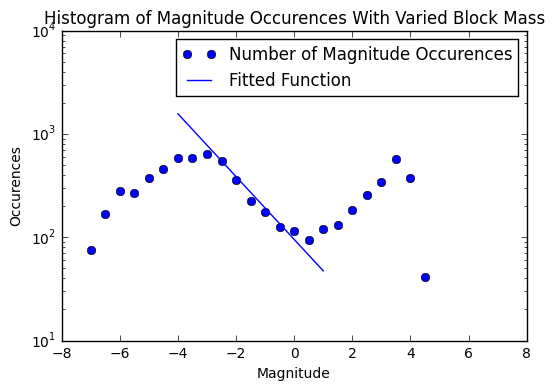

Total Number of Earthquakes:  7056


In [31]:
bigOccurences = [ 75, 167, 281, 268, 372, 455, 579, 579, 634, 542, 358, 222, 177, 126, 115,  93, 119, 132,
 182, 255, 345, 565, 374,  41,   0,   0,   0,   0,   0]
bigMagnitudes = np.linspace(-7, 7, 29)

A = 95
b = 0.7
fitX = np.linspace(-4, 1)
fitY = []
for i in fitX:
    fitY.append(A * np.exp(-b * i))
    
plt.semilogy(bigMagnitudes, bigOccurences, "b o", label = "Number of Magnitude Occurences")
plt.semilogy(fitX, fitY, label = "Fitted Function")
plt.title("Histogram of Magnitude Occurences With Varied Block Mass")
plt.xlabel("Magnitude")
plt.ylabel("Occurences")
plt.legend(loc = "best")
plt.show()

print("Total Number of Earthquakes: ", sum(bigOccurences))

The above plot is a histogram representing the number of earthquakes that occur within certain magnitude ranges in a large timeframe. This data was collected over 5000000 time steps and there were 100 blocks with mass that varied from 0.5 mass units to 2 mass units. The results show a total of 7056 earthquakes. The plot is scaled the same way as the above plot to shows that there is decaying exponential trend between magnitudes -3 and 1. Over this range, the estimated function that fits the data is $P(M) = 95e^{-0.7M}$, where M is the magnitude. Here, the b value, 0.7, is lower than the values we see in nature, and it is slightly lower than the value that we obtained using uniform masses.

## Analysis

The first example model shows the position and velocity of a system with 25 blocks over a short amount of time (t = 0 to ~600). The purpose of this model was to depict how the blocks move over a relatively short time scale. From the plots of position and velocity over time, we can see that there are a wide range of earthquake sizes, and some involve all of the blocks, while others involve only a small portion of them. In the following plot that depicts earthquake magnitudes over time, we can see the pattern in which the earthquakes tend to occur. It appears from this plot that each large earthquake tends to be preceded by a number of smaller ones. This is important because it provides evidence that the earth's crust is not continuously in a state of self-organized criticality, but that this state builds up over time. If this model was in a constant state of self-organized criticality, we would see a random fluctuation in earthquake magnitude.

After this initial example, I took the same data over a much larger portion of time with 5000000 time steps and 100 blocks. Then I complied this into a histogram that depicts how often earthquakes with certain magnitudes occur. The purpose of this was to see how accurate the model is compared to what we see in nature. According to real-life statistics, the b value should be between 0.8 and 1.5. From my model, I obtained a b value of 0.8 which is at the lower end of this scale. In addition, there is an excess of large earthquakes that was not taken into account when finding the b value. There are many possible reasons for this. One is that I only used 100 blocks, so the motion of one block is still somewhat highly influential to the overall model. Another is that the friction force model may not be accurate. Also the model has uniform block masses and kc values, so I decided to test weather this was a factor by running another simulation with varied block masses. 

The last plot shown is the histogram of various magnitudes and their occurrences in a system with varied block masses, from 0.5 to 2 mass units. Every other perimeter is exactly the same as the prior simulation. The b value I obtained from this was 0.7, which is less accurate than the prior simulation, but within the range of possible error. From this I can infer that how varied the masses are does not have much of an effect on the model. One reason why the b value might be lower is because the average mass was raised to 1.25 mass units. To be get more conclusive data, I might run more simulations on different systems of blocks with various masses. 

Overall, this model appears to be accurate for earthquakes in a range of magnitudes from -3 to 1 magnitude units. If this model is accurate, it provides evidence that the earth is not in a continuous state of self-organized criticality.

## Summary

### Scientific Summary

### Personal Summary

## Sources:

[1] Giordano N. 1997. Computational Physics. Upper Sadie River, NJ: Pretence-Hall inc. p. 315-328

[2] Sammis C, Smith S. 1999. Seismic Cycles and the Evolution of Stress Correlation in Cellular
Automaton Models of Finite Fault Networks. Pure and Applied Geophysics. 155(1)

In [22]:
if __name__ == "__main__":
    import doctest
    doctest.testmod()